# Notebook Setup

In [1]:
# All modules
import os
import cv2
import glob
import uuid
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import torchvision.utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# My files
from SiameseNetwork import SiameseNetwork
from SiameseData import SiameseNetworkDataset, app_Data

In [2]:
# Check if pytorch can read the GPU or not
if torch.cuda.is_available():
  print("GPU available!")
  device = torch.device('cuda')
else:
  print("GPU not available. Training on CPU.")

GPU available!


# Preparing the data

In [3]:
# Resize the images into 100x100 and transform to tensors
transformation = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

In [4]:
# Function to plot the images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
"""
I downloded the at&t dataset that has already train and test folders but I am also increasing the dataset by adding images for me in the dataset
and also I am taking some images for the verification folder so I can use it later to verify my identity using the siamese network.
"""
cap = cv2.VideoCapture(0)
counter = 1

while cap.isOpened():
  ret, frame = cap.read()

  # Cut down frame to 250x250px
  frame = frame[120:120+250, 200:200+250, :]

  # Collect images for training
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(r"data\faces\MyData", '{}.jpg'.format(counter))
    counter += 1
    # Changing the images into grayscale 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize it into 100x100
    frame = cv2.resize(frame, (100, 100))
    # Save it
    cv2.imwrite(imgname, frame)
  
  # Collect images for verification folder
  if cv2.waitKey(1) & 0XFF == ord('v'):
    imgname = os.path.join(r"VerificationData", '{}.jpg'.format(uuid.uuid1()))
  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (100, 100))
    cv2.imwrite(imgname, frame)

  cv2.imshow('Image Collection', frame)

  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

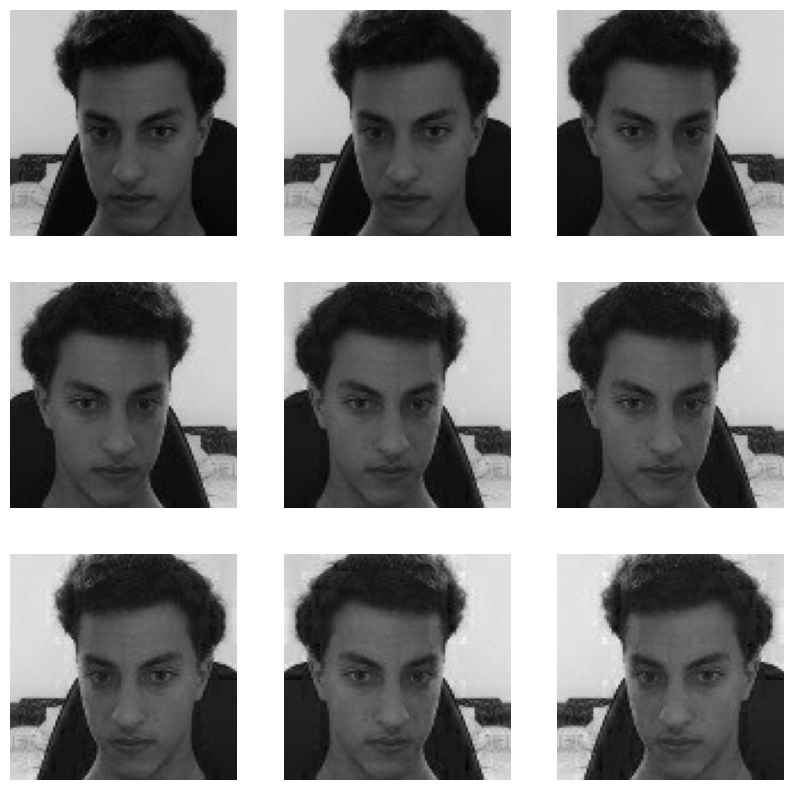

In [5]:
# Testing data_aug method to increase the number of images and generating new images from existing images.
exp_image = r'data\faces\MyData\8.jpg'

img = cv2.imread(exp_image)
augmented_images = SiameseNetworkDataset.data_aug(img)
num_images = len(augmented_images)
rows = 3
cols = 3

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(augmented_images[i][:,:,::-1])
    plt.axis('off')

plt.show()

### Extracting faces

In [6]:
# Save only the face for training data using save_face method
images = glob.glob(os.path.join(r"data\faces\MyData", '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join(r"data\faces\training\s41", os.path.basename(img))):
    pass
  else:
    try:
      SiameseNetworkDataset.save_face(img, r"data\faces\training\s41")
    except:
      pass

In [7]:
# Save only the face for verification data
images = glob.glob(os.path.join(r"VerificationData", '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join(r"application_data\input_image\verification_images", os.path.basename(img))):
    pass
  else:
    try:
      SiameseNetworkDataset.save_face(img, r"application_data\input_image\verification_images")
    except:
      pass

### Data Augmentation

In [8]:
# Here I am using data_aug method on my images and save them that is for training the model
names = 10

for file_name in tqdm(os.listdir(os.path.join(r"data\faces\training\s41"))):
  img_path = os.path.join(r"data\faces\training\s41", file_name)
  img = cv2.imread(img_path)
  augmented_images = SiameseNetworkDataset.data_aug(img)

  for image in augmented_images:
    names += 1
    cv2.imwrite(os.path.join(r"data\faces\training\s41", '{}.jpg'.format(names)), image.numpy())

In [9]:
# And also for the verification folder 
for file_name in tqdm(os.listdir(os.path.join(r"application_data\input_image\verification_images"))):
  img_path = os.path.join(r"application_data\input_image\verification_images", file_name)
  img = cv2.imread(img_path)
  augmented_images = SiameseNetworkDataset.data_aug(img)

  for image in augmented_images:
    names += 1
    cv2.imwrite(os.path.join(r"application_data\input_image\verification_images", '{}.jpg'.format(uuid.uuid1())), image.numpy())

### Load training data

In [10]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=r"data\faces\training")

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)

In [11]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=2, batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [12]:
train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=64)

# Training The Model

In [13]:
# Making the model run on the GPU
SNN = SiameseNetwork().cuda()

SNN.to(device)

In [14]:
# Giving the model the number of Epochs, Dataset and Learning rate
SNN.train(75, train_dataloader, 0.0005)
# Ploting the stats of the model during training
SNN.show_plot()

In [15]:
# Save the model
torch.save(SNN, 'SNN')

In [4]:
# Load Model
SNN = torch.load("SNN")

SNN.to(device)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

# Evaluating The Model

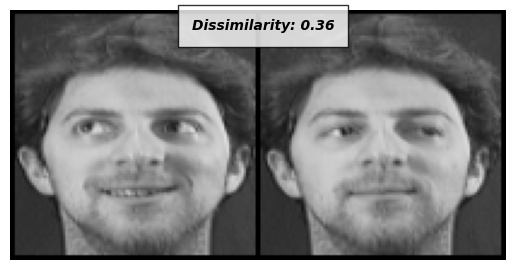

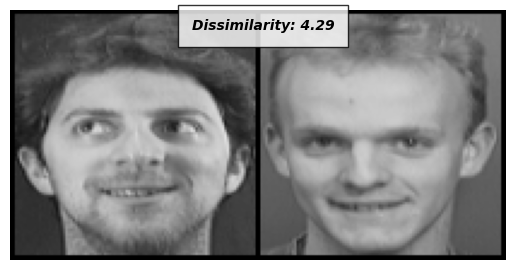

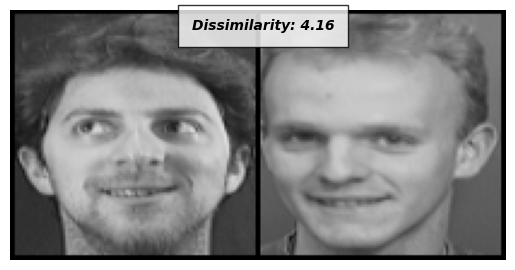

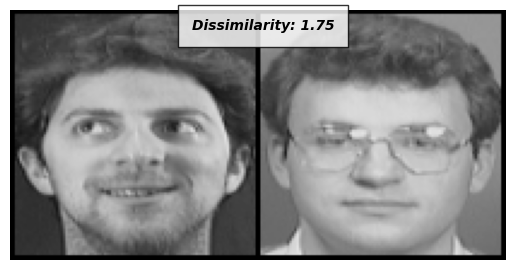

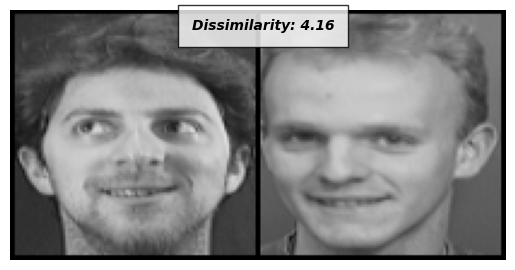

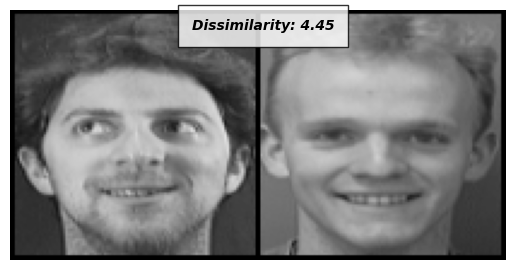

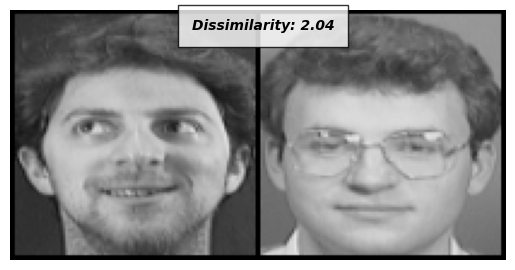

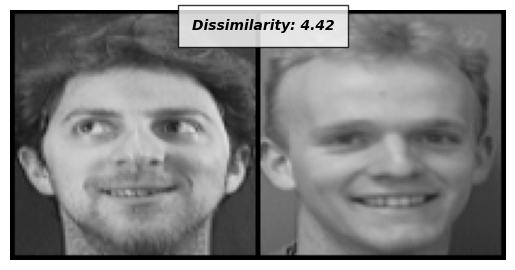

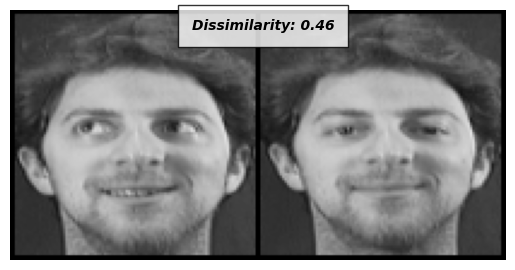

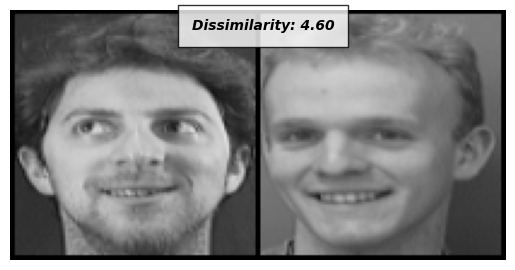

In [6]:
# Load test dataset
folder_dataset_test = datasets.ImageFolder(root=r"data\faces\testing")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = SNN(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

# Real Time Predictions

In [5]:
# A method to check the if the model has found a similar person or not with threshold of 0.5 
def state(arr):
    for result in arr:
        if result < 0.5:
            return True

In [6]:
def verify():
  # Loading the application dataset
  folder_dataset_test = datasets.ImageFolder(root=r"application_data\input_image")
  applicationData = app_Data(imageFolderDataset=folder_dataset_test, transform=transformation)
  dataloader = DataLoader(applicationData, num_workers=2, batch_size=1, shuffle=True)
  # Making the predictions and return array of the results the model has done
  results = SNN.predict(dataloader)
  
  # Now check if the model has found similarity or not
  if state(results):
    return "Matches"
  else:
    return "Does not match"

In [8]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  cv2.imshow('Verification', frame)

  # Verification trigger
  if cv2.waitKey(7) & 0xFF == ord('v'):
    # Save the captured image of the user
    cv2.imwrite('application_data/input_image/input_image.jpg', frame)
    SiameseNetworkDataset.save_face('application_data/input_image/input_image.jpg', 'application_data/input_image')
    status = verify()
    print(status)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 90ms/step
Matches
1/1 [==============================] - 0s 202ms/step
Does not match
